In [14]:
import os, platform, glob, numpy as np
import pretty_midi
from pypianoroll import Multitrack
from scipy.io import wavfile as spw
from pydub import AudioSegment as AS
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

### MIDIデータの探索

In [8]:
base_dir = "../datasets/theorytab/pianoroll"

In [9]:
def files(directory):
    file_list = glob.glob(f"{directory}/*")
    file_list.sort()
    return file_list

In [15]:
initials = files(base_dir)
artists = files(initials[0])
songs = files(artists[3])
midis = glob.glob(f"{songs[0]}/*.mid")
[print(mid) for mid in midis]

../datasets/theorytab/pianoroll/a/a-ha/take-on-me/verse-and-pre-chorus_key.mid
../datasets/theorytab/pianoroll/a/a-ha/take-on-me/intro-and-verse_key.mid
../datasets/theorytab/pianoroll/a/a-ha/take-on-me/intro-and-verse_nokey.mid
../datasets/theorytab/pianoroll/a/a-ha/take-on-me/verse-and-pre-chorus_nokey.mid
../datasets/theorytab/pianoroll/a/a-ha/take-on-me/intro_nokey.mid
../datasets/theorytab/pianoroll/a/a-ha/take-on-me/chorus_key.mid
../datasets/theorytab/pianoroll/a/a-ha/take-on-me/chorus_nokey.mid
../datasets/theorytab/pianoroll/a/a-ha/take-on-me/intro_key.mid


[None, None, None, None, None, None, None, None]

### MIDIデータの読み込みと可視化

[Track(pianoroll=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), program=0, is_drum=False, name=), Track(pianoroll=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), program=0, is_drum=False, name=)]


(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdab3b645f8>,
       dtype=object))

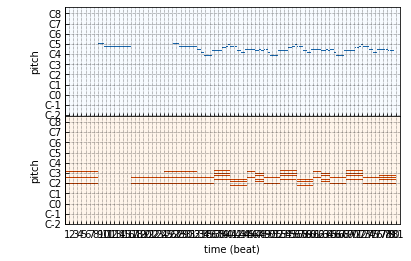

In [16]:
midi_path = midis[1]
midi_data = Multitrack(midi_path)
print(midi_data.tracks)
midi_data.plot()

### MIDIデータをWAVEファイルとして書き出し

In [12]:
def soundfont():
    soundfont = ""
    
    pf = platform.system()
    
    # ubuntu
    if pf == 'Linux':
        soundfont = "../gsfont/gsfont.sf2"

    # mac
    if pf == 'Darwin':
        soundfont = "./data/GeneralUser_GS_v1.471.sf2"
    
    return soundfont

def pm_to_wave(pm, wave_file_name, sf_path, fs=44100):
    
    audio = pm.fluidsynth(fs, sf_path)
    
    # 16bit=2byte符号付き整数に変換してノーマライズ [-32768  ~ 32767]
    audio = np.array(audio * 32767.0, dtype="int16") # floatだと情報量が多くなる
    audio_stereo = np.c_[audio, audio] # ステレオ化
    spw.write(wave_file_name, fs, audio_stereo) # 書き出し
    
    return audio

メロディパートが目立つように楽器を変更  
[楽器一覧](https://www.midi.org/specifications/item/gm-level-1-sound-set)
(プログラム番号は楽器番号-1)

In [15]:
program = 90
midi_data.tracks[0].program = program
pretty_midi.program_to_instrument_name(program)

'Pad 3 (polysynth)'

In [16]:
wave_file_name = f"./data/{midi_path.split('/')[6]}.wav"

In [ ]:
audio = pm_to_wave(midi_data.to_pretty_midi(), wave_file_name, soundfont())
print(len(audio))
plt.plot(audio)
Audio(wave_file_name)

### waveファイルをmp3に変換
1/10くらいのサイズにできる  
導入  
```
$ pip install pydub
$ apt-get install ffmpeg -y
```

In [ ]:
sound = AS.from_wav(wave_file_name)
mp3_file_name = f"{wave_file_name[:-4]}.mp3"
sound.export(mp3_file_name, format="mp3")
os.remove(wave_file_name)
Audio(mp3_file_name)

# 解析ファイル作成
データセットに関する情報をまとめてCSVにする  

In [1]:
import os, platform, glob, numpy as np
import pandas as pd
from pretty_midi import PrettyMIDI, KeySignature
from pretty_midi import key_number_to_key_name, key_name_to_key_number
from pypianoroll import Multitrack
from pypianoroll.metrics import polyphonic_rate
from utils import steps_to_bars, pos_to_sec
from utils import estimate_key_signature_changes
from utils import in_scale_rates
from pathlib import Path
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
%matplotlib inline

base_dir = "../datasets/theorytab/pianoroll"
output_path = "./data/theorytab.csv"

cpu_count()

20

### 単一MIDIデータに対する処理

In [2]:
class SeriesData():
    columns = []
    
    def series(self, columns=None, no_column_found=""):
        data = []
        for attr in columns or self.columns:
            data.append(getattr(self, attr, no_column_found)())
        return pd.Series(data, columns or self.columns)

In [3]:
class EmptyMIDIError(ValueError):
    pass

class TheoryTabSeriesData(SeriesData):
    columns = [
        "path", "artist", "song", "part", "nokey",
        "key_signature", "estimated_key_signature", 
        "in_scale_rate", "estimated_in_scale_rate", "highest", "lowest", 
        "bpm", "time_signature", "beats", "bars", "time", 
        "has_melody_track", "has_chord_track"
    ]

    
    def __init__(self, midi_path):
        self.midi_path = midi_path
        self.split_path = midi_path.split("/")

        self.pretty_midi = PrettyMIDI(midi_path)

        if self.pretty_midi.instruments == []:
            raise EmptyMIDIError("MIDI is empty")
            
        self.pm_melody = self.pretty_midi.instruments[0]

        self.pianoroll = Multitrack(midi_path)
        self.pr_melody = self.pianoroll.tracks[0]
    
    def path(self):
        return "/".join(self.split_path[-4:])
    
    def artist(self):
        return self.split_path[-3]
    
    def song(self):
        return self.split_path[-2]
    
    def part(self):
        return ",".join(self.split_path[-1].split(".")[0].split("_")[0].split("-and-"))
    
    def nokey(self):
        return self.split_path[-1].split(".")[0].split("_")[-1] == "nokey"
    
    def key_signature(self):
        # [0, 11] Major, [12, 23] minor
        return ",".join([key_number_to_key_name(ks.key_number) for ks in self.pretty_midi.key_signature_changes])
    
    def estimated_key_signature(self, by_name=True):
        index = [0, 1] if self.has_melody_track() else None
        if by_name:
            keys = ",".join(estimate_key_signature_changes(self.pretty_midi, index=index))
        else:
            keys = ",".join([str(ks) for ks in estimate_key_signature_changes(self.pretty_midi, index=index, by_name=False)])
        return keys
    
    def in_scale_rate(self):
        index = [0, 1] if self.has_melody_track() else None
        key_changes = self.pretty_midi.key_signature_changes
        scale_rates = in_scale_rates(self.pretty_midi, key_changes=key_changes, index=index)
        return ','.join([str(sr) for sr in scale_rates])
    
    def estimated_in_scale_rate(self):
        index = [0, 1] if self.has_melody_track() else None
        keys = [int(ks) for ks in self.estimated_key_signature(by_name=False).split(",")]
        key_changes = []
        for key, kc in zip(keys, self.pretty_midi.key_signature_changes):
            key_changes.append(KeySignature(key, kc.time))
        scale_rates = in_scale_rates(self.pretty_midi, key_changes=key_changes, index=index)
        return ','.join([str(sr) for sr in scale_rates])

    def highest(self):
        if not self.has_melody_track(): return np.nan
        return float(self.pr_melody.get_active_pitch_range()[1])
    
    def lowest(self):
        if not self.has_melody_track(): return np.nan
        return float(self.pr_melody.get_active_pitch_range()[0])
    
    def bpm(self):
        return ",".join(list(set(str(int(tempo)) for tempo in self.pianoroll.tempo)))
    
    def time_signature(self):
        time_signatures = self.pretty_midi.time_signature_changes
        time_signatures = [f"{ts.numerator}/{ts.denominator}" for ts in time_signatures]
        return ",".join(time_signatures)
    
    def resolution(self):
        return self.pianoroll.beat_resolution
    
    def beats(self):
        return int(np.ceil(len(self.pr_melody.pianoroll) / self.resolution()))
    
    def bars(self):
        return steps_to_bars(self.pretty_midi, self.pr_melody.pianoroll.shape[0], self.resolution())
    
    def time(self):
        return round(self.pretty_midi.get_end_time(), 2)
    
    def has_melody_track(self):
        if len(self.pianoroll.tracks) > 1:
            return True
        elif polyphonic_rate(self.pianoroll.tracks[0].pianoroll) > 0.5:
            return False
        else:
            return True
    
    def has_chord_track(self):
        if len(self.pianoroll.tracks) > 1:
            return True
        elif polyphonic_rate(self.pianoroll.tracks[0].pianoroll) > 0.5:
            return True
        else:
            return False

#### 単一処理テスト

In [4]:
def files(directory):
    file_list = glob.glob(f"{directory}/*")
    file_list.sort()
    return file_list

initials = files(base_dir)
artists = files(initials[0])
songs = files(artists[3])
midis = glob.glob(f"{songs[0]}/*.mid")
midi_path = midis[1]
print(midi_path)

midi_data = Multitrack(midi_path)

../datasets/theorytab/pianoroll/a/a-ha/take-on-me/intro-and-verse_key.mid


In [5]:
data = TheoryTabSeriesData(midi_path)
series = data.series()
series

path                       a/a-ha/take-on-me/intro-and-verse_key.mid
artist                                                          a-ha
song                                                      take-on-me
part                                                     intro,verse
nokey                                                          False
key_signature                                                A Major
estimated_key_signature                                     F# minor
in_scale_rate                                                    1.0
estimated_in_scale_rate                                          1.0
highest                                                           85
lowest                                                            71
bpm                                                              168
time_signature                                                   4/4
beats                                                             81
bars                              

### 複数MIDIデータに対する処理

#### パス取得テスト

In [6]:
paths = Path(base_dir).glob("**/*.mid") # generator
path_list = [str(path) for path in paths]
print(len(path_list))
path_list[:10]

39752


['../datasets/theorytab/pianoroll/q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid',
 '../datasets/theorytab/pianoroll/q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_nokey.mid',
 '../datasets/theorytab/pianoroll/q/queen-and-bowie/under-pressure/intro-and-verse_key.mid',
 '../datasets/theorytab/pianoroll/q/queen-and-bowie/under-pressure/intro-and-verse_nokey.mid',
 '../datasets/theorytab/pianoroll/q/queen-and-bowie/under-pressure/intro_nokey.mid',
 '../datasets/theorytab/pianoroll/q/queen-and-bowie/under-pressure/intro_key.mid',
 '../datasets/theorytab/pianoroll/q/qweqwe/qweqwe/intro_nokey.mid',
 '../datasets/theorytab/pianoroll/q/qweqwe/qweqwe/intro_key.mid',
 '../datasets/theorytab/pianoroll/q/queen/the-show-must-go-on/intro-and-verse_key.mid',
 '../datasets/theorytab/pianoroll/q/queen/the-show-must-go-on/intro-and-verse_nokey.mid']

#### マルチプロセス処理の実行

In [7]:
paths = Path(base_dir).glob("**/*.mid") # generator

empties = []
def extract(path): 
    try:
        return TheoryTabSeriesData(path).series()
    except EmptyMIDIError:
        empties.append(path)
        return None

p = Pool()
series_data = [midi for midi in p.map(extract, path_list) if midi is not None]

#### 処理結果の確認

In [8]:
print(len(empties))

0


In [9]:
df = pd.DataFrame(series_data, columns=TheoryTabSeriesData.columns)
df.sort_values(by="path")
print(len(df))
df.head()

39614


,path,artist,song,part,nokey,key_signature,estimated_key_signature,in_scale_rate,estimated_in_scale_rate,highest,lowest,bpm,time_signature,beats,bars,time,has_melody_track,has_chord_track
0,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,False,Bb Major,Bb Major,0.88278,0.88278,73.0,65.0,146,4/4,48,12,19.73,True,True
1,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,True,Bb Major,C Major,0.74186,0.88278,63.0,55.0,146,4/4,48,12,19.73,True,True
2,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",False,D Major,D Major,1.0,1.0,73.0,57.0,120,4/4,32,8,16.00,True,True
3,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",True,D Major,C Major,0.74297,1.0,71.0,55.0,120,4/4,32,8,16.00,True,True
4,q/queen-and-bowie/under-pressure/intro_nokey.mid,queen-and-bowie,under-pressure,intro,True,D Major,C Major,0.65812,1.0,71.0,55.0,240,4/4,32,8,8.00,True,True


#### CSVへ保存

In [10]:
df.to_csv(output_path)